# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.misc import imread, imresize
import datetime
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#Load Data

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
# batch_size = #experiment with the batch size

In [4]:
directory = "/mnt/disks/user/project/PROJECT/Project_data/train"
childDirectories = next(os.walk(directory))[1]
df_train = pd.DataFrame(childDirectories,columns =['Names'])
df_train = df_train["Names"].str.split("_", n = 6, expand = True)
df_train = df_train.drop(df_train.columns[[0, 1, 2, 3, 4, 5]], axis=1)
df_train[6].value_counts()

Right_Swipe_new                  103
Thumbs_Down_new                  100
Left_Swipe_new                    96
Stop_new                          93
Thumbs_Up_new                     87
Left Swipe_new_Left Swipe_new     40
Thumbs Down_new                   37
Stop Gesture_new                  37
Thumbs Up_new                     36
Right Swipe_new                   34
Name: 6, dtype: int64

In [5]:
directory = "/mnt/disks/user/project/PROJECT/Project_data/val"
childDirectories = next(os.walk(directory))[1]
df_val = pd.DataFrame(childDirectories,columns =['Names'])
df_val = df_val["Names"].str.split("_", n = 6, expand = True)
df_val = df_val.drop(df_val.columns[[0, 1, 2, 3, 4, 5]], axis=1)
df_val[6].value_counts()

Stop_new                         14
Left_Swipe_new                   13
Right_Swipe_new                  13
Thumbs_Down_new                  12
Thumbs_Up_new                    10
Right Swipe_new                  10
Thumbs Down_new                   9
Stop Gesture_new                  8
Thumbs Up_new                     6
Left Swipe_new_Left Swipe_new     5
Name: 6, dtype: int64

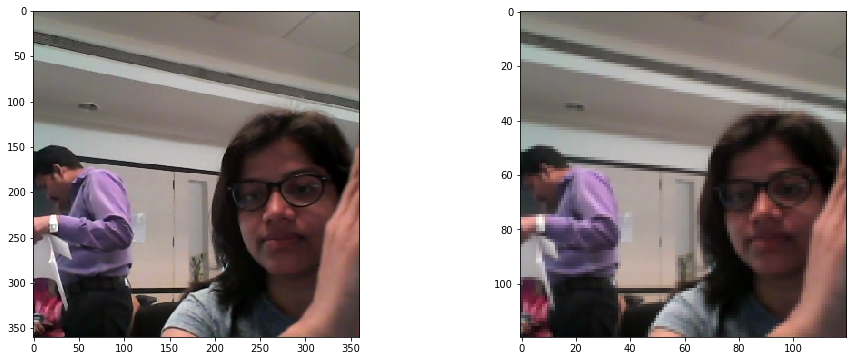

In [6]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
img = imread('Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
plt.imshow(img)

plt.subplot(1,2,2)
img1 = imresize(img,(120,120))
plt.imshow(img1)

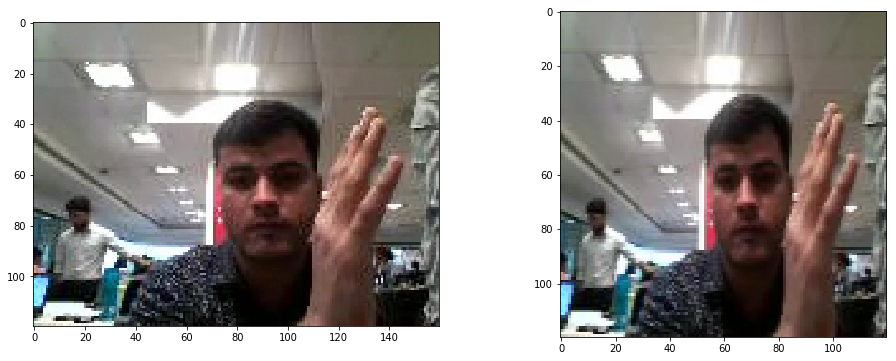

In [7]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
img2 = imread('Project_data/train/WIN_20180926_18_07_05_Pro_Right_Swipe_new/WIN_20180926_18_07_05_Pro_00009.png')
plt.imshow(img2)

plt.subplot(1,2,2)
img_2 = imresize(img2,(120,120))
plt.imshow(img_2)

In [8]:
batch_size = 10
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

## Image Normalization Reference:
https://datascience.stackexchange.com/questions/26881/data-preprocessing-should-we-normalise-images-pixel-wise

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 - Layers=4, BS = 10, Epoch = 10

In [12]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

#write your model here

# Model 1
# One input and output layer
# 4 Convolutional and max pooling layers to obtain the most important/informatic features
# 2 Dense layers followed by dropout

model_1 = Sequential()

model_1.add(Conv3D(8,kernel_size=(3,3,3), input_shape=(x,y,z,channel), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))


model_1.add(Conv3D(16,kernel_size=(3,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))


model_1.add(Conv3D(32,kernel_size=(3,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))


model_1.add(Conv3D(64,kernel_size=(3,3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_1.add(Flatten())
model_1.add(Dense(1000, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(500, activation='relu'))
model_1.add(Dropout(0.5))

#softmax layer
model_1.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [138]:
history1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - 81s 1s/step - loss: 2.3768 - categorical_accuracy: 0.2815 - val_loss: 1.1923 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-03-0208_04_45.054330/model-00001-2.39555-0.27753-1.19230-0.47000.h5
Epoch 2/30
67/67 [==============================] - 23s 350ms/step - loss: 1.9978 - categorical_accuracy: 0.3383 - val_loss: 1.3687 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-03-0208_04_45.054330/model-00002-1.99778-0.33831-1.36871-0.39000.h5
Epoch 3/30
67/67 [==============================] - 25s 377ms/step - loss: 1.8435 - categorical_accuracy: 0.3234 - val_loss: 1.1242 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-03-0208_04_45.054330/model-00003-1.84348-0.32338-1.12418-0.51000.h5
Epoch 4/30
67/67 [==============================] - 25s 37

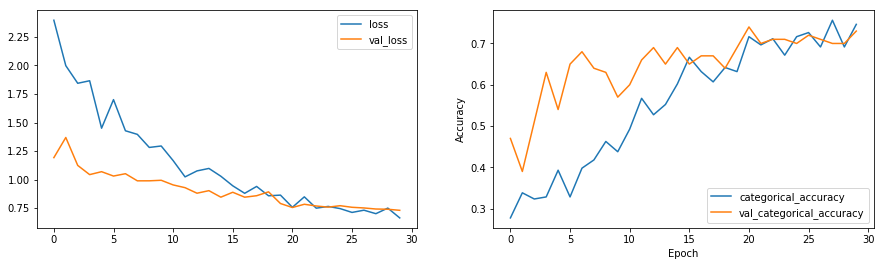

In [140]:
plot(history1)

### Model 1.1 - Layers=4, BS = 10, Epoch = 50

In [142]:
batch_size = 10
num_epochs = 50

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_37 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_37 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_38 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_38 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [143]:
history1_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - 80s 1s/step - loss: 0.7361 - categorical_accuracy: 0.7194 - val_loss: 0.7198 - val_categorical_accuracy: 0.7400

Epoch 00001: saving model to model_init_2020-03-0208_04_45.054330/model-00001-0.74126-0.71644-0.71983-0.74000.h5
Epoch 2/50
67/67 [==============================] - 26s 384ms/step - loss: 0.8700 - categorical_accuracy: 0.6468 - val_loss: 0.9114 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-03-0208_04_45.054330/model-00002-0.87002-0.64677-0.91138-0.65000.h5
Epoch 3/50
67/67 [==============================] - 26s 393ms/step - loss: 0.8577 - categorical_accuracy: 0.6517 - val_loss: 0.7976 - val_categorical_accuracy: 0.7300

Epoch 00003: saving model to model_init_2020-03-0208_04_45.054330/model-00003-0.85768-0.65174-0.79759-0.73000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 

67/67 [==============================] - 27s 406ms/step - loss: 0.3830 - categorical_accuracy: 0.8756 - val_loss: 0.6557 - val_categorical_accuracy: 0.7700

Epoch 00027: saving model to model_init_2020-03-0208_04_45.054330/model-00027-0.38303-0.87562-0.65565-0.77000.h5
Epoch 28/50
67/67 [==============================] - 26s 388ms/step - loss: 0.3464 - categorical_accuracy: 0.8706 - val_loss: 0.6588 - val_categorical_accuracy: 0.7700

Epoch 00028: saving model to model_init_2020-03-0208_04_45.054330/model-00028-0.34637-0.87065-0.65883-0.77000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 29/50
67/67 [==============================] - 28s 411ms/step - loss: 0.3599 - categorical_accuracy: 0.8657 - val_loss: 0.6582 - val_categorical_accuracy: 0.7700

Epoch 00029: saving model to model_init_2020-03-0208_04_45.054330/model-00029-0.35989-0.86567-0.65821-0.77000.h5
Epoch 30/50
67/67 [==============================] - 27s 408ms/step - loss: 0.3828 - 

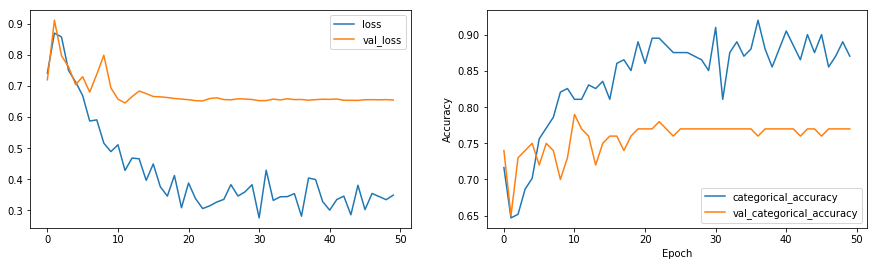

In [144]:
plot(history1_1)

### Model 1.2 - Layers=4, BS = 30, Epoch = 25

In [49]:
batch_size = 30
num_epochs = 50

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history1_2 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/50
67/67 [==============================] - 99s 1s/step - loss: 0.5475 - categorical_accuracy: 0.8153 - val_loss: 0.9382 - val_categorical_accuracy: 0.6438

Epoch 00001: saving model to model_init_2020-03-0103_42_01.488557/model-00001-0.46606-0.83774-0.93818-0.64375.h5
Epoch 2/50
67/67 [==============================] - 25s 377ms/step - loss: 0.7871 - categorical_accuracy: 0.7363 - val_loss: 0.7799 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2020-03-0103_42_01.488557/model-00002-0.78707-0.73632-0.77994-0.75000.h5
Epoch 3/50
67/67 [==============================] - 26s 385ms/step - loss: 0.7612 - categorical_accuracy: 0.7811 - val_loss: 0.8656 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-03-0103_42_01.488557/model-00003-0.76122-0.78109-0.86563-0.69000.h5
Epoch 4/50
67/67 [==============================] - 26s 39

67/67 [==============================] - 26s 385ms/step - loss: 0.1467 - categorical_accuracy: 0.9353 - val_loss: 0.6743 - val_categorical_accuracy: 0.7700

Epoch 00027: saving model to model_init_2020-03-0103_42_01.488557/model-00027-0.14673-0.93532-0.67428-0.77000.h5
Epoch 28/50
67/67 [==============================] - 26s 394ms/step - loss: 0.1981 - categorical_accuracy: 0.9303 - val_loss: 0.5899 - val_categorical_accuracy: 0.7800

Epoch 00028: saving model to model_init_2020-03-0103_42_01.488557/model-00028-0.19813-0.93035-0.58991-0.78000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 29/50
67/67 [==============================] - 26s 390ms/step - loss: 0.1484 - categorical_accuracy: 0.9552 - val_loss: 0.8357 - val_categorical_accuracy: 0.7400

Epoch 00029: saving model to model_init_2020-03-0103_42_01.488557/model-00029-0.14837-0.95522-0.83566-0.74000.h5
Epoch 30/50
67/67 [==============================] - 27s 402ms/step - loss: 0.1622 -

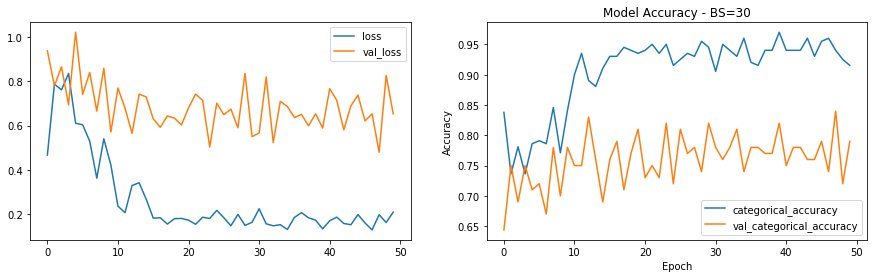

In [50]:
plot(history1_2)

### Model 1.3 - Layers=4, BS = 50, Epoch = 25

In [47]:
batch_size = 50
num_epochs = 15

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history1_3 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 50
Source path =  Epoch 1/15
Project_data/train ; batch size = 50
67/67 [==============================] - 178s 3s/step - loss: 2.4238 - categorical_accuracy: 0.3279 - val_loss: 1.0847 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-03-0107_48_39.134194/model-00001-2.78767-0.29586-1.08474-0.57000.h5
Epoch 2/15
67/67 [==============================] - 116s 2s/step - loss: 1.4147 - categorical_accuracy: 0.5040 - val_loss: 0.9359 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2020-03-0107_48_39.134194/model-00002-1.41468-0.50402-0.93590-0.68000.h5
Epoch 3/15
67/67 [==============================] - 116s 2s/step - loss: 1.0900 - categorical_accuracy: 0.6051 - val_loss: 0.8572 - val_categorical_accuracy: 0.7400

Epoch 00003: saving model to model_init_2020-03-0107_48_39.134194/model-00003-1.08996-0.60505-0.85717-0.74000.h5
Epoch 4/15
67/67 [==============================] - 118s 2s/s

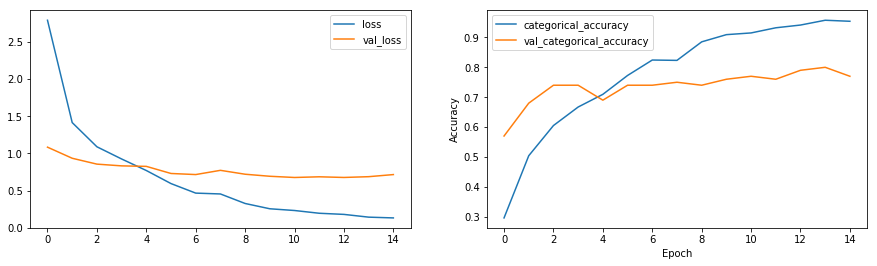

In [48]:
plot(history1_3)

### Model 2 - Layers=4, BS = 20, Epoch = 15, Dropout

In [ ]:
from keras import regularizers
# Model 2
# One input and output layer
# 4 Convolutional and max pooling layers to obtain the most important/informatic features
# 2 Dense layers followed by dropout
# Dropout after each covolutional layer and 

batch_size = 20
num_epochs = 15
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

model_2 = Sequential()

model_2.add(Conv3D(8,kernel_size=(3,3,3), input_shape=(x,y,z,channel), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv3D(16,kernel_size=(3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv3D(32,kernel_size=(3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv3D(64,kernel_size=(3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(Dropout(0.25))

#Flatten Layers
model_2.add(Flatten())
model_2.add(Dense(1000, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(500, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [ ]:
train_generator2 = generator(train_path, train_doc, batch_size)
val_generator2 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

In [38]:
history2 = model_2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - 83s 2s/step - loss: 3.7522 - categorical_accuracy: 0.2421 - val_loss: 1.3201 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-03-0105_39_36.344055/model-00001-3.79458-0.23982-1.32010-0.44000.h5
Epoch 2/40
34/34 [==============================] - 12s 363ms/step - loss: 2.8219 - categorical_accuracy: 0.2745 - val_loss: 1.2270 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-03-0105_39_36.344055/model-00002-2.82187-0.27451-1.22696-0.50000.h5
Epoch 3/40
34/34 [==============================] - 14s 417ms/step - loss: 2.4760 - categorical_accuracy: 0.4314 - val_loss: 1.3743 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-03-0105_39_36.344055/model-00003-2.47602-0.43137-1.37425-0.38000.h5
Epoch 4/40
34/34 [==============================] - 14s 40


Epoch 00026: saving model to model_init_2020-03-0105_39_36.344055/model-00026-1.77129-0.37255-1.20741-0.52000.h5

Epoch 00026: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 27/40
34/34 [==============================] - 16s 475ms/step - loss: 1.5967 - categorical_accuracy: 0.4902 - val_loss: 1.2006 - val_categorical_accuracy: 0.5100

Epoch 00027: saving model to model_init_2020-03-0105_39_36.344055/model-00027-1.59674-0.49020-1.20057-0.51000.h5
Epoch 28/40
34/34 [==============================] - 16s 483ms/step - loss: 1.7397 - categorical_accuracy: 0.4216 - val_loss: 1.1916 - val_categorical_accuracy: 0.5200

Epoch 00028: saving model to model_init_2020-03-0105_39_36.344055/model-00028-1.73974-0.42157-1.19162-0.52000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 29/40
34/34 [==============================] - 16s 480ms/step - loss: 2.0274 - categorical_accuracy: 0.3627 - val_loss: 1.1891 - val_categorical_accuracy

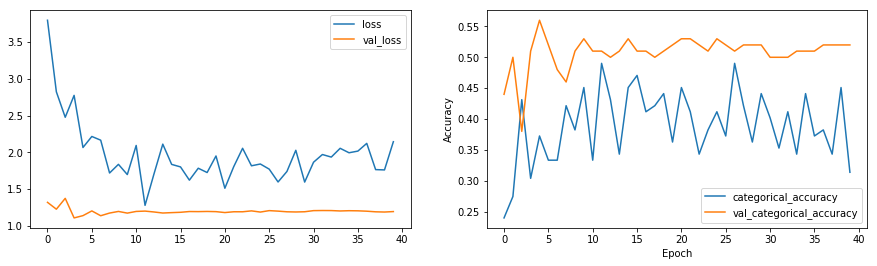

In [39]:
plot(history2)

### Model 3 - Layers=4, BS = 30, Epoch = 30, filter 2x2

In [41]:
def generator_1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [46]:
from keras import regularizers
# Model 3
# One input and output layer
# 4 Convolutional and max pooling layers to obtain the most important/informatic features
# 2 Dense layers followed by dropout
# Dropout after each covolutional layer and 
# Filter size (2x2x2)

batch_size = 30
num_epochs = 30

model_3 = Sequential()

model_3.add(Conv3D(16,kernel_size=(2,2,2), input_shape=(x,y,z,channel), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32,kernel_size=(2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))


model_3.add(Conv3D(64,kernel_size=(2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))


model_3.add(Conv3D(128,kernel_size=(2,2,2), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5))

#softmax layer
model_3.add(Dense(5, activation='softmax'))


In [47]:
train_generator3 = generator_1(train_path, train_doc, batch_size)
val_generator3 = generator_1(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_34 (Conv3D)           (None, 30, 120, 120, 16)  400       
_________________________________________________________________
activation_34 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_35 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 15, 60, 60, 32)    128       
__________

In [48]:
history3 = model_3.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30
Epoch 1/30
34/34 [==============================] - 87s 3s/step - loss: 2.0116 - categorical_accuracy: 0.2522 - val_loss: 1.4921 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-03-0105_39_36.344055/model-00001-2.15734-0.22845-1.49209-0.40000.h5
Epoch 2/30
34/34 [==============================] - 10s 292ms/step - loss: 1.5759 - categorical_accuracy: 0.2745 - val_loss: 1.5828 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2020-03-0105_39_36.344055/model-00002-1.57586-0.27451-1.58285-0.18000.h5
Epoch 3/30
34/34 [==============================] - 14s 411ms/step - loss: 1.6102 - categorical_accuracy: 0.2255 - val_loss: 1.4552 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-03-0105_39_36.344055/model-00003-1.61021-0.22549-1.45515-0.44000.h5
Epoch 4/30
34/34 [==============================] - 13s 36

34/34 [==============================] - 14s 404ms/step - loss: 1.5610 - categorical_accuracy: 0.2353 - val_loss: 1.5947 - val_categorical_accuracy: 0.2800

Epoch 00026: saving model to model_init_2020-03-0105_39_36.344055/model-00026-1.56104-0.23529-1.59472-0.28000.h5
Epoch 27/30
34/34 [==============================] - 13s 381ms/step - loss: 1.5859 - categorical_accuracy: 0.2549 - val_loss: 1.5655 - val_categorical_accuracy: 0.3200

Epoch 00027: saving model to model_init_2020-03-0105_39_36.344055/model-00027-1.58587-0.25490-1.56552-0.32000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 28/30
34/34 [==============================] - 13s 384ms/step - loss: 1.5770 - categorical_accuracy: 0.2843 - val_loss: 1.5759 - val_categorical_accuracy: 0.2800

Epoch 00028: saving model to model_init_2020-03-0105_39_36.344055/model-00028-1.57698-0.28431-1.57592-0.28000.h5
Epoch 29/30
34/34 [==============================] - 14s 419ms/step - loss: 1.6074 - 

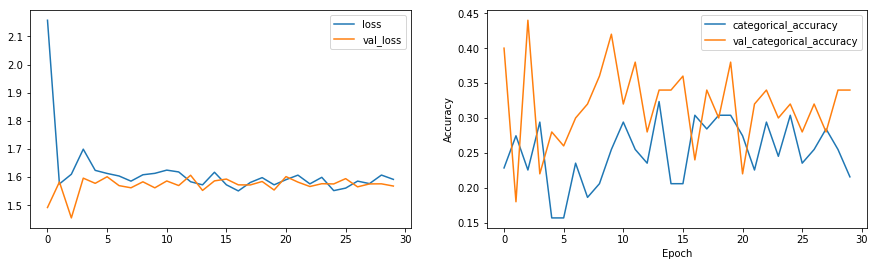

In [49]:
plot(history3)

### Model 4 - Layers=4, BS = 30, Epoch = 30, filter 3x3, image size = 160x160

In [16]:
batch_size = 30
num_epochs = 35
x = 30 # # x is the number of images
y = 160 # width of the image
z = 160 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [17]:
def generator_2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [22]:
# Model 4


model_4 = Sequential()

model_4.add(Conv3D(16,kernel_size=(3,3,3), input_shape=(x,y,z,channel), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

model_4.add(Conv3D(32,kernel_size=(3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))


model_4.add(Conv3D(64,kernel_size=(3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))


model_4.add(Conv3D(128,kernel_size=(3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))

#softmax layer
model_4.add(Dense(5, activation='softmax'))


In [23]:
train_generator4 = generator_2(train_path, train_doc, batch_size)
val_generator4 = generator_2(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 80, 80, 32)    128       
__________

In [27]:
history4 = model_4.fit_generator(train_generator4, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator4, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train Epoch 1/35
; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 103s 4s/step - loss: 2.3232 - categorical_accuracy: 0.2201 - val_loss: 1.5087 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-03-0107_26_12.185584/model-00001-2.35565-0.21569-1.50866-0.36000.h5
Epoch 2/35
23/23 [==============================] - 7s 321ms/step - loss: 1.7130 - categorical_accuracy: 0.2174 - val_loss: 1.4268 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-03-0107_26_12.185584/model-00002-1.71302-0.21739-1.42681-0.25000.h5
Epoch 3/35
23/23 [==============================] - 11s 486ms/step - loss: 1.7855 - categorical_accuracy: 0.2609 - val_loss: 1.6612 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2020-03-0107_26_12.185584/model-00003-1.78552-0.26087-1.66121-0.20000.h5
Epoch 4/35
23/23 [====================

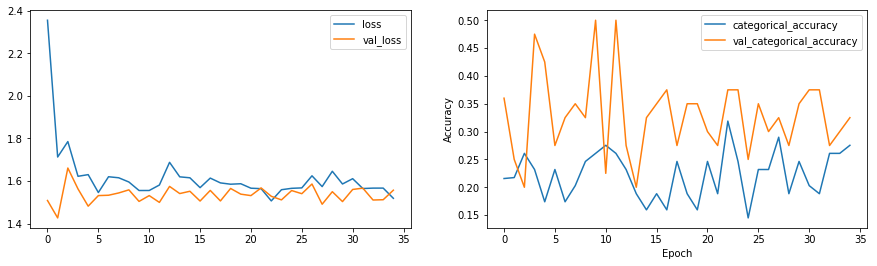

In [29]:
plot(history4)

### Model 5 CNN+LSTM

In [29]:
batch_size = 30
num_epochs = 15
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [30]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

model_5 = Sequential()
model_5.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,channel)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2,2))))

model_5.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',	activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',	activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Flatten()))
model_5.add(LSTM(1024))

model_5.add(Dense(512,activation='relu'))
model_5.add(Dropout(0.25))

model_5.add(Dense(5, activation='softmax'))
model_5.add(Dropout(0.25))


In [31]:
train_generator5 = generator(train_path, train_doc, batch_size)
val_generator5 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0002) #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [32]:
history5 = model_5.fit_generator(train_generator5, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 30
 ; batch size = 30
Epoch 1/15
Batch:  4 Index: 30
67/67 [==============================] - 102s 2s/step - loss: 1.1697 - categorical_accuracy: 0.2030 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.1688

Epoch 00001: saving model to model_init_2020-03-0213_40_59.345727/model-00001-2.89228-0.24025-0.00000-0.16875.h5
Epoch 2/15
67/67 [==============================] - 26s 387ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.2239 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-03-0213_40_59.345727/model-00002-0.00000-0.22388-0.00000-0.16000.h5
Epoch 3/15
67/67 [==============================] - 28s 412ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.1841 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2020-03-0213_40_59.345727/model-00003-0.00000-0.18408-0.00000-0.18000.h5

Epoch 00003: Red

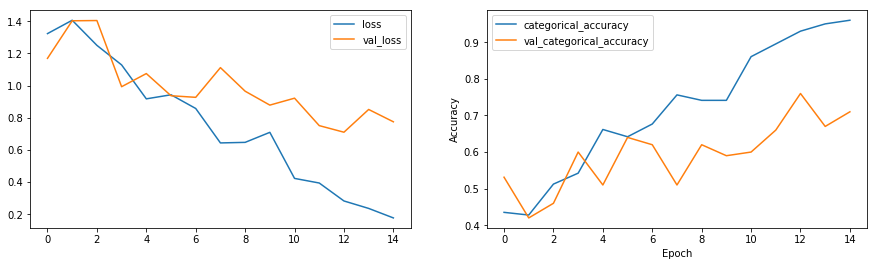

In [57]:
plot(history5)

### Model 5_1 BS=10

In [58]:
batch_size = 10
num_epochs = 20

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history5_1 = model_5.fit_generator(train_generator5, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 34s 505ms/step - loss: 0.2546 - categorical_accuracy: 0.9154 - val_loss: 0.9346 - val_categorical_accuracy: 0.6500

Epoch 00001: saving model to model_init_2020-03-0107_48_39.134194/model-00001-0.25462-0.91542-0.93464-0.65000.h5
Epoch 2/20
67/67 [==============================] - 27s 405ms/step - loss: 0.2703 - categorical_accuracy: 0.9204 - val_loss: 1.0058 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-03-0107_48_39.134194/model-00002-0.27034-0.92040-1.00579-0.66000.h5
Epoch 3/20
67/67 [==============================] - 30s 442ms/step - loss: 0.2166 - categorical_accuracy: 0.9303 - val_loss: 0.8567 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-03-0107_48_39.134194/model-00003-0.21658-0.93035-0.85670-0.67000.h5
Epoch 4/20
67/67 [==============================] - 29s 440ms/step - loss: 0.2912 - categorical_accuracy: 0.9154 - val_loss: 0.8076 - val_categorical_accurac

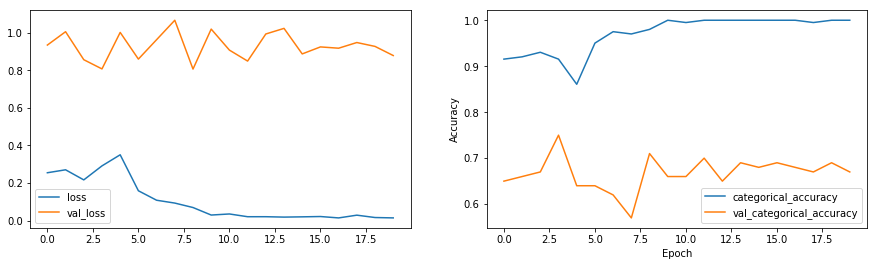

In [59]:
plot(history5_1)

### Model 6 Transfer Learning

In [17]:
batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [18]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

17227776/17225924 [==============================] - 2s 0us/step


In [19]:
model_6 = Sequential()
model_6.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(128))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(5, activation='softmax'))

In [20]:
train_generator6 = generator(train_path, train_doc, batch_size)
val_generator6 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [21]:
history6 = model_6.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train Epoch 1/20
; batch size = 10
67/67 [==============================] - 223s 3s/step - loss: 1.6455 - categorical_accuracy: 0.3084 - val_loss: 1.3029 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-03-0213_40_59.345727/model-00001-1.65082-0.30468-1.30288-0.52000.h5
Epoch 2/20
67/67 [==============================] - 29s 436ms/step - loss: 1.4106 - categorical_accuracy: 0.4279 - val_loss: 1.1861 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-03-0213_40_59.345727/model-00002-1.41065-0.42786-1.18610-0.54000.h5
Epoch 3/20
67/67 [==============================] - 29s 434ms/step - loss: 1.3523 - categorical_accuracy: 0.4428 - val_loss: 1.0850 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-03-0213_40_59.345727/model-00003-1.35225-0.44279-1.08502-0.58000.h5
Epoch 4/20
67/67 [==============================] - 30s 4

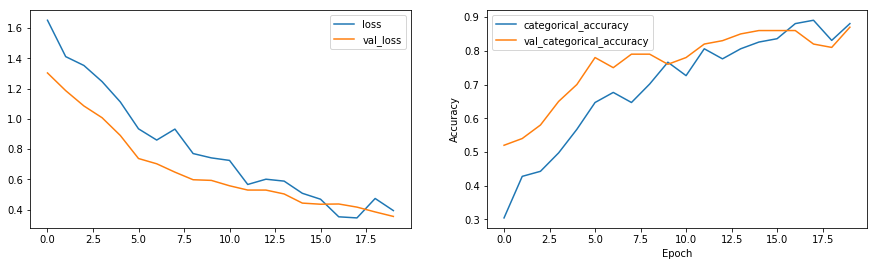

In [22]:
plot(history6)

In [25]:
batch_size = 10
num_epochs = 25
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB


model_61 = Sequential()
model_61.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_61.add(TimeDistributed(BatchNormalization()))
model_61.add(TimeDistributed(MaxPooling2D((2, 2))))
model_61.add(TimeDistributed(Flatten()))

model_61.add(GRU(256))
model_61.add(Dropout(0.3))

model_61.add(Dense(256,activation='relu'))
model_61.add(Dropout(0.3))

model_61.add(Dense(5, activation='softmax'))

In [26]:
train_generator61 = generator(train_path, train_doc, batch_size)
val_generator61 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_61.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_61.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               983808    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
__________

In [27]:
history61 = model_61.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - 40s 594ms/step - loss: 1.5863 - categorical_accuracy: 0.3234 - val_loss: 0.9592 - val_categorical_accuracy: 0.7600

Epoch 00001: saving model to model_init_2020-03-0213_40_59.345727/model-00001-1.58627-0.32338-0.95917-0.76000.h5
Epoch 2/25
67/67 [==============================] - 29s 428ms/step - loss: 1.0244 - categorical_accuracy: 0.6418 - val_loss: 0.6766 - val_categorical_accuracy: 0.8400

Epoch 00002: saving model to model_init_2020-03-0213_40_59.345727/model-00002-1.02436-0.64179-0.67657-0.84000.h5
Epoch 3/25
67/67 [==============================] - 29s 428ms/step - loss: 0.8064 - categorical_accuracy: 0.7214 - val_loss: 0.5225 - val_categorical_accuracy: 0.8500

Epoch 00003: saving model to model_init_2020-03-0213_40_59.345727/model-00003-0.80640-0.72139-0.52248-0.85000.h5
Epoch 4/25
67/67 [==============================] - 30s 445ms/step - loss: 0.7146 - categorical_accuracy: 0.7612 - val_loss: 0.4100 - val_categorical_accurac

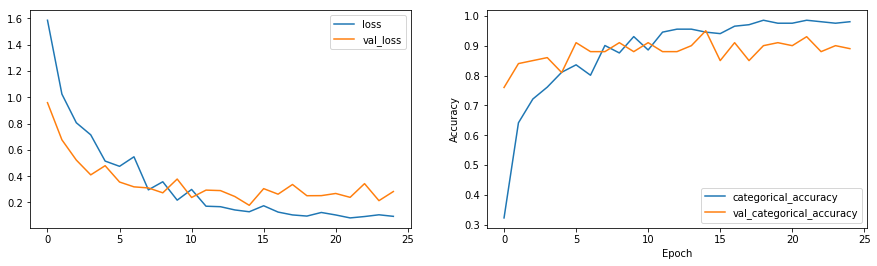

In [28]:
plot(history61)

### Model 7: CNN2D + GRU

In [33]:
batch_size = 10
num_epochs = 20
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [38]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

model_7 = Sequential()
model_7.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape=(x,y,z,channel)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(64, (3, 3),padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_7.add(TimeDistributed(Flatten()))
model_7.add(LSTM(1024))

model_7.add(Dense(512,activation='relu'))
model_7.add(Dropout(0.25))

model_7.add(Dense(5, activation='softmax'))
model_7.add(Dropout(0.25))


In [39]:
train_generator7 = generator(train_path, train_doc, batch_size)
val_generator7 = generator(val_path, val_doc, batch_size)

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [41]:
history7 = model_7.fit_generator(train_generator5, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator5, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 36s 534ms/step - loss: 5.0310 - categorical_accuracy: 0.3881 - val_loss: 1.0329 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-03-0213_40_59.345727/model-00001-5.03096-0.38806-1.03292-0.60000.h5
Epoch 2/20
67/67 [==============================] - 32s 481ms/step - loss: 5.5025 - categorical_accuracy: 0.4328 - val_loss: 1.1560 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-03-0213_40_59.345727/model-00002-5.50245-0.43284-1.15601-0.53000.h5
Epoch 3/20
67/67 [==============================] - 32s 482ms/step - loss: 4.6899 - categorical_accuracy: 0.4925 - val_loss: 1.0043 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-03-0213_40_59.345727/model-00003-4.68990-0.49254-1.00432-0.68000.h5
Epoch 4/20
67/67 [==============================] - 32s 483ms/step - loss: 3.4829 - categorical_accuracy: 0.5672 - val_loss: 1.0228 - val_categorical_accurac

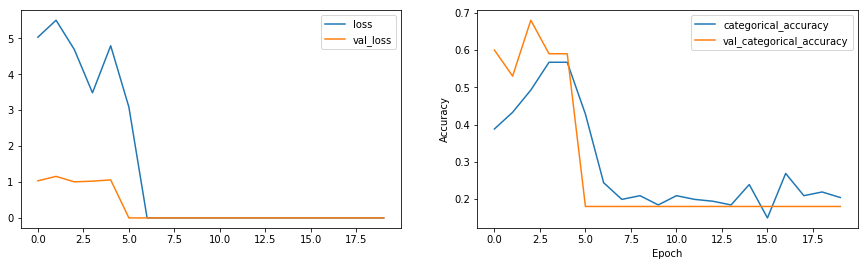

In [42]:
plot(history7)